# HPC Mini-Challenge 2 - Beschleunigung in Data Science
## Teil 2: GPU
#### FHNW - FS22

Original von S. Suter, angepasst für das HS22 von S. Marcin

Abgabe von: <font color='blue'>Name hier eintragen</font>

#### Ressourcen
* [Überblick GPU Programmierung](https://www.cherryservers.com/blog/introduction-to-gpu-programming-with-cuda-and-python)
* [CUDA Basic Parts](https://nyu-cds.github.io/python-gpu/02-cuda/)
* [Accelerate Code with CuPy](https://towardsdatascience.com/heres-how-to-use-cupy-to-make-numpy-700x-faster-4b920dda1f56)
* Vorlesungen und Beispiele aus dem Informatikkurs PAC (parallel computing), siehe resourcen
* CSCS "High-Performance Computing with Python" Kurs, Tag 3: 
    - JIT Numba GPU 1 + 2
    - https://youtu.be/E4REVbCVxNQ
    - https://github.com/eth-cscs/PythonHPC/tree/master/numba-cuda
    - Siehe auch aktuelles Tutorial von 2021
* [Google CoLab](https://colab.research.google.com/) oder ggf. eigene GPU.


In [ ]:
#!pip install numba

In [ ]:
#!/opt/miniconda3/bin/python

import math
from numba import vectorize, cuda, float32, float64
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import multiprocessing as mp
import sys
plt.rcParams['figure.figsize'] = (16,9)
device = cuda.get_current_device()

In [ ]:
!nvidia-smi

Thu Jun 15 07:25:46 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    25W /  70W |    103MiB / 15360MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Dummy Beispiel zum testen mit Numba

import math
from numba import vectorize, cuda, float32
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16,9)

@vectorize(['float32(float32)'], target='cuda')
def gpu_sqrt(x):
    return math.sqrt(x)


a = np.arange(4096,dtype=np.float32)
gpu_sqrt(a)

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 4 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


array([ 0.       ,  1.       ,  1.4142135, ..., 63.97656  , 63.98437  ,
       63.992188 ], dtype=float32)

In [ ]:
device = cuda.get_current_device()
print("Number of Multiprocessors:\t\t", device.MULTIPROCESSOR_COUNT)
print("Max. Number of Threads per Block:\t", device.MAX_THREADS_PER_BLOCK)
print("Max. Threads per Multiprocessor:\t", device.MAX_THREADS_PER_MULTI_PROCESSOR)
print()
print("Max. Block Dimension in X:\t\t", device.MAX_BLOCK_DIM_X)
print("Max. Block Dimension in Y:\t\t", device.MAX_BLOCK_DIM_Y)
print("Max. Block Dimension in Z:\t\t", device.MAX_BLOCK_DIM_Z)
print()
print("Max. Grid Dimension in X:\t\t", device.MAX_GRID_DIM_X)
print("Max. Grid Dimension in Y:\t\t", device.MAX_GRID_DIM_Y)
print("Max. Grid Dimension in Z:\t\t", device.MAX_GRID_DIM_Z)

Number of Multiprocessors:		 40
Max. Number of Threads per Block:	 1024
Max. Threads per Multiprocessor:	 1024

Max. Block Dimension in X:		 1024
Max. Block Dimension in Y:		 1024
Max. Block Dimension in Z:		 64

Max. Grid Dimension in X:		 2147483647
Max. Grid Dimension in Y:		 65535
Max. Grid Dimension in Z:		 65535


### 5 GPU Rekonstruktion

Implementiere eine SVD-Rekonstruktionsvariante auf der GPU oder in einem hybriden Setting. Code aus dem ersten Teil darf dabei verwendet werden. Wähle  bewusst, welche Teile des Algorithms in einem GPU Kernel implementiert werden und welche effizienter auf der CPU sind. Ziehe dafür Erkenntnisse aus dem ersten Teil mit ein. Es muss mindestens eine Komponente des Algorithmuses in einem GPU-Kernel implementiert werden. Dokumentiere Annahmen, welche du ggf. zur Vereinfachung triffst. Evaluiere, ob du mit CuPy oder Numba arbeiten möchtest.

Links:
* [Examples: Matrix Multiplikation](https://numba.readthedocs.io/en/latest/cuda/examples.html)

#### 5.1 Testing CUDA

In [ ]:
@cuda.jit
def naive_matrix_multiplication(a, b, c):
    '''
    Perform matrix multiplication of c = a @ b.
    The matrix c has to be in the shape of a.shape[0] and b.shape[1].
    Returns updated c
    '''
    i, j = cuda.grid(2)
    if i < c.shape[0] and j < c.shape[1]:
        tmp = 0.
        for k in range(a.shape[1]):
            tmp += a[i, k] * b[k, j]
        c[i, j] = tmp

@cuda.jit
def naive_elementwise_multiplication(a,b,c):
    i,j = cuda.grid(2)

    if i < c.shape[0] and j < c.shape[1]:
        c[i,j] = a[i,j] * b[i,j]

In [ ]:
# create arrays
a_h = np.arange(16).reshape((4,4))
b_h = np.ones((4, 8))
c_h = np.zeros((a_h.shape[0], b_h.shape[1]))

# send arrays to gpu
a_d = cuda.to_device(a_h)
b_d = cuda.to_device(b_h)
c_d = cuda.to_device(c_h)

threadsperblock = (16,16)

threadsperblock = (16, 16)
blockspergrid_x = math.ceil(c_h.shape[0] / threadsperblock[0])
blockspergrid_y = math.ceil(c_h.shape[1] / threadsperblock[1])
blockspergrid = (blockspergrid_x, blockspergrid_y)

naive_matrix_multiplication[blockspergrid, threadsperblock](a_d, b_d, c_d)
c_h = c_d.copy_to_host()
np.testing.assert_allclose(c_h, a_h @ b_h)
print(np.vstack((c_h, a_h @ b_h)))

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


[[ 6.  6.  6.  6.  6.  6.  6.  6.]
 [22. 22. 22. 22. 22. 22. 22. 22.]
 [38. 38. 38. 38. 38. 38. 38. 38.]
 [54. 54. 54. 54. 54. 54. 54. 54.]
 [ 6.  6.  6.  6.  6.  6.  6.  6.]
 [22. 22. 22. 22. 22. 22. 22. 22.]
 [38. 38. 38. 38. 38. 38. 38. 38.]
 [54. 54. 54. 54. 54. 54. 54. 54.]]


In [ ]:
# create arrays
a_h = np.arange(16, dtype=np.float32).reshape((4,4))
b_h = np.ones((4, 4), dtype=np.float32) * 2
c_h = np.zeros((a_h.shape[0], b_h.shape[1]), dtype=np.float32)

# send arrays to gpu
a_d = cuda.to_device(a_h)
b_d = cuda.to_device(b_h)
c_d = cuda.to_device(c_h)

threadsperblock = (16,16)

threadsperblock = (16, 16)
blockspergrid_x = math.ceil(c_h.shape[0] / threadsperblock[0])
blockspergrid_y = math.ceil(c_h.shape[1] / threadsperblock[1])
blockspergrid = (blockspergrid_x, blockspergrid_y)

naive_elementwise_multiplication[blockspergrid, threadsperblock](a_d, b_d, c_d)
c_h = c_d.copy_to_host()
np.testing.assert_allclose(c_h, a_h * b_h)
print(np.vstack((c_h, a_h @ b_h)))

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


[[  0.   2.   4.   6.]
 [  8.  10.  12.  14.]
 [ 16.  18.  20.  22.]
 [ 24.  26.  28.  30.]
 [ 12.  12.  12.  12.]
 [ 44.  44.  44.  44.]
 [ 76.  76.  76.  76.]
 [108. 108. 108. 108.]]


In [ ]:
### BEGIN SOLUTION
@cuda.jit
def svd_reconstruction(u, s, vt, reco):
    i, j = cuda.grid(2)

    if i < u.shape[0] and j < vt.shape[1]:
        tmp = 0.
        for m in range(u.shape[1]):
            tmp += u[i, m] * s[m, 0] * vt[m, j]
        reco[i, j] = tmp

def reconstruct_svd(u:np.array, s:np.array, vt:np.array, k:int):
    """SVD reconstruction for k components using broadcast variant 1

    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components

    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    # create arrays
    u_h = u[:, :k]
    s_h = s[:k].reshape((k,1))
    vt_h = vt[:k, :]
    reco_h = np.zeros((u_h.shape[0], vt_h.shape[1]))

    # send to device
    u_d = cuda.to_device(u_h)
    s_d = cuda.to_device(s_h)
    vt_d = cuda.to_device(vt_h)
    reco_d = cuda.to_device(reco_h)

    threadsperblock = (16, 16)
    blockspergrid_x = math.ceil(reco_h.shape[0] / threadsperblock[0])
    blockspergrid_y = math.ceil(reco_h.shape[1] / threadsperblock[1])
    blockspergrid = (blockspergrid_x, blockspergrid_y)

    svd_reconstruction[blockspergrid, threadsperblock](u_d, s_d, vt_d, reco_d)

    result = reco_d.copy_to_host()

    return result


k = 100
test = np.random.random((100,100))
u, s, vt = np.linalg.svd(test)

np.testing.assert_allclose(test, reconstruct_svd(u, s, vt, k))
### END SOLUTION

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 49 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


<font color='blue'>Antwort hier eingeben</font>
Die einfache SVD-Rekonstruktion berechnet die Rekonstruktion der Matrix komplett auf der GPU. Es ist nicht notwendig, dass Arbeitsschritte seriell durchgeführt werden. Solange das Ende aller Threads abgewartet wird sollte das Resultat übereinstimmen.

Diese einfache Implementation hat noch Optimierungspotenzial. Die gleichen Matrixelemente werden mehrmals geladen. Eine gute Möglichkeit wäre die Verwendung des Shared Memorys. Das Shared Memory ist viel schneller und kann von allen Threads innerhalb eines Blocks verwendet werden. Dadurch gäbe es nur eine Input- und eine Outputoperation zwischen CPU und GPU. Zudem könnte auch die Grid-Size noch angepasst werden, wie die Meldung der vorherigen Codezelle vorschlägt.

Es wird Numba verwendet, da die Befehle für die GPU selbst geschrieben werden können und nicht nur Pythoncode vektorisiert wird.

#### 5.2 GPU-Kernel Performance

##### 5.3.1 Blocks und Input-Grösse

Links: 
* [Examples: Matrix Multiplikation](https://numba.readthedocs.io/en/latest/cuda/examples.html)
* [NVIDIA Kapitel zu "Strided Access"](https://spaces.technik.fhnw.ch/multimediathek/file/cuda-best-practices-in-c)
* https://developer.nvidia.com/blog/cublas-strided-batched-matrix-multiply/
* https://developer.nvidia.com/blog/how-access-global-memory-efficiently-cuda-c-kernels/

Führe 2-3 Experimente mit unterschiedlichen Blockkonfigurationen und Grösse der Input-Daten durch. Erstelle dafür ein neues Datenset mit beliebig grossen Matrizen, da die GPU besonders geeignet ist um grosse Inputs zu verarbeiten (Verwende diese untschiedlich grossen Matrizen für alle nachfolgenden Vergeliche und Tasks ebenfalls). Messe die Performance des GPU-Kernels mittels geeigneten Funktionen. Welche Blockgrösse in Abhängigkeit mit der Input-Grösse hat sich bei dir basierend auf deinen Experimenten als am erfolgreichsten erwiesen? Welches sind deiner Meinung nach die Gründe dafür? Wie sind die Performance Unterschiede zwischen deiner CPU und GPU Implementierung? Diskutiere deine Analyse (ggf. mit Grafiken).

In [ ]:
### BEGIN SOLUTION
@cuda.jit
def svd_reconstruction(u, s, vt, reco):
    i, j = cuda.grid(2)

    if i < u.shape[0] and j < vt.shape[1]:
        tmp = 0.
        for m in range(u.shape[1]):
            tmp += u[i, m] * s[m, 0] * vt[m, j]
        reco[i, j] = tmp

# generate matrices
np.random.seed(42)
matrices = {}

matrix_sizes = [(500, 500), (1000, 1000), (2000, 2000), (2500, 2500), (3000, 3000), (5000, 5000), (10000, 10000)]  #  matrices have to be bigger than kernel size

thread_sizes = [(16, 16), (32, 32), (16, 64), (64, 16), (128, 8), (8, 128)]

times_matrix_sizes, std_matrix_sizes = [], []
stream = cuda.stream()

for matrix_size in matrix_sizes:
    with cuda.pinned():
        print("Matrix size: ", matrix_size)
        u_h = np.random.random(matrix_size).astype(np.float32)
        s_h = np.random.random((matrix_size[0], 1)).astype(np.float32)
        vt_h = np.random.random(matrix_size).astype(np.float32)
        reco_h = np.zeros(matrix_size).astype(np.float32)

        with cuda.defer_cleanup():
            start = datetime.now()
            print(f"0: {(datetime.now() - start).total_seconds()}")
            u_d = cuda.to_device(u_h, stream=stream)
            print(f"1: {(datetime.now() - start).total_seconds()}")
            s_d = cuda.to_device(s_h, stream=stream)
            print(f"2: {(datetime.now() - start).total_seconds()}")
            vt_d = cuda.to_device(vt_h, stream=stream)
            print(f"3: {(datetime.now() - start).total_seconds()}")
            reco_d = cuda.to_device(reco_h, stream=stream)
            print(f"4: {(datetime.now() - start).total_seconds()}")
            stream.synchronize()
            end = datetime.now()

    print("Transfer Time [s]: ", (end - start).total_seconds())

    times_thread_sizes, std_thread_sizes = [], []

    for thread_size in thread_sizes:
        print("Thread size: ", thread_size)
        blockspergrid_x = math.ceil(reco_h.shape[0] / thread_size[0])
        blockspergrid_y = math.ceil(reco_h.shape[1] / thread_size[1])
        blockspergrid = (blockspergrid_x, blockspergrid_y)
        times = []
        for i in range(5):
            start = datetime.now()
            svd_reconstruction[blockspergrid, thread_size, stream, 0](u_d, s_d, vt_d, reco_d)
            stream.synchronize()
            process_time_gpu = (datetime.now() - start).total_seconds()
            print(f"kernel: {process_time_gpu}")
            times.append(process_time_gpu)

        times_thread_sizes.append(np.median(times)), std_thread_sizes.append(np.std(times))

    times_matrix_sizes.append(times_thread_sizes), std_matrix_sizes.append(std_thread_sizes)

    del u_d, u_h
    del s_d, s_h
    del vt_d, vt_h
    del reco_d, reco_h

### END SOLUTION

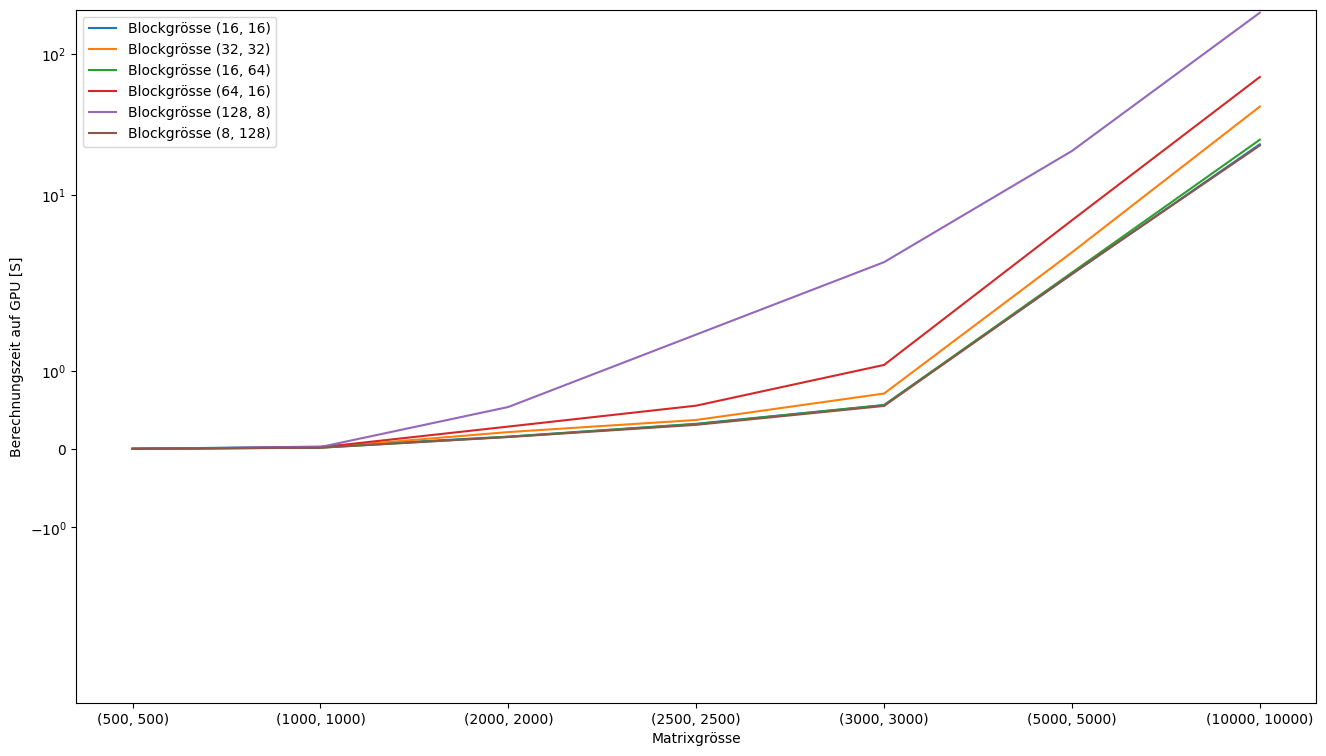

In [ ]:
fig, ax = plt.subplots()
for time_thread_size, thread_size in zip(np.array(times_matrix_sizes).T, thread_sizes):
    ax.plot(time_thread_size, label=f"Blockgrösse {str(thread_size)}")
ax.set_xticks(list(range(7)))
ax.set_xticklabels([str(matrix_size) for matrix_size in matrix_sizes])
plt.ylabel("Berechnungszeit auf GPU [S]")
plt.xlabel("Matrixgrösse")
plt.legend()
plt.yscale('symlog')
plt.show()

<font color='blue'>Antwort hier eingeben</font>
Auffallend ist, dass die Transferzeiten von Host zu Device stark variieren. Bei dieser Ausführung ist die Transferzeit für die (3000,3000) Matrix über 20 Sekunden lang. Bei verschiedenen Experimenten konnte festgestellt werden, dass die Transferzeit auch bei anderen Matrizengrössen stark variierte.

Der Hauptgrund für die Zeitunterschiede ist hauptsächlich das Memory Access Pattern des Warps auf das Global Memory, bei der Berechnung der Rekonstruktionsmatrix.

Bei Blockgrössen mit einer kleineren Dimension in der X-Achse als in der Y-Achse, z.B. (8,128) wird beim Memory Access ein Strided Pattern verwendet. Da die SVD-Rekonstruktion eine for-Loop verwendet, werden die Werte in der ersten Spalte der $U$ Matrix innerhalb eines Warps geladen. Dies resultiert in einem Strided Access. Von der $S$ und $V^T$ Matrix wird jeweils nur ein Wert geladen.

Bei Blockgrössen mit einer grösseren Dimension in der X-Achse als in der Y-Achse, z.B. (128,8)  wird beim Memory Access ein Coalesced Pattern verwendet. Bei der SVD-Rekonstruktion werden in einer Schlaufe der for-Loop alle Werte der ersten Reihe der $V^T$ Matrix geladen. Dies resultiert in einem Coalesced Access. Von der $U$ und $S$ Matrix wird jeweils nur ein Wert geladen.

Die beiden Beispiele sind in der nächsten Abbildung visualisiert.


Dies bestätigen auch die gemessenen Zeiten für die Berechnung der Rekonstruktion. Je kleiner die Dimension in der Y-Achse des Blocks, desto schneller sind die Berechnungszeiten.

Die Blockgrösse (16,16) ist leicht schneller als die Blockgrösse (16,64). Dies liegt wohl daran, dass pro Warp mehr Werte für die Blockgrösse (16,64) geladen werden, auch wenn dies mit dem Coalesced Access Pattern geschieht.

In [ ]:
def calc_info(matrix_dim, block_dim):
    print(f"Anzahl Blöcke für Matrix {matrix_dim} und Blockgrösse {block_dim}:")
    print(math.ceil(matrix_dim[0] / block_dim[0]) * math.ceil(matrix_dim[1] / block_dim[1]))
    print(f"Anzahl Threads für Blockgrösse {block_dim}: ", block_dim[0] * block_dim[1])

In [ ]:
calc_info((2000,2000), (16,16))
calc_info((2000,2000), (32,32))
calc_info((2000,2000), (64,16))
calc_info((2000,2000), (128,8))

Anzahl Blöcke für Matrix (2000, 2000) und Blockgrösse (16, 16):
15625
Anzahl Threads für Blockgrösse (16, 16):  256
Anzahl Blöcke für Matrix (2000, 2000) und Blockgrösse (32, 32):
3969
Anzahl Threads für Blockgrösse (32, 32):  1024
Anzahl Blöcke für Matrix (2000, 2000) und Blockgrösse (64, 16):
4000
Anzahl Threads für Blockgrösse (64, 16):  1024
Anzahl Blöcke für Matrix (2000, 2000) und Blockgrösse (128, 8):
4000
Anzahl Threads für Blockgrösse (128, 8):  1024


##### 5.2.2 Shared Memory auf der GPU
Optimiere deine Implementierung von oben indem du das shared Memory der GPU verwendest. Führe wieder mehrere Experimente mit unterschiedlicher Datengrösse durch und evaluiere den Speedup gegenüber der CPU Implementierung.

Links:
* [Best Practices Memory Optimizations](https://docs.nvidia.com/cuda/cuda-c-best-practices-guide/index.html#memory-optimizations)
* [Examples: Matrix Multiplikation und Shared Memory](https://numba.readthedocs.io/en/latest/cuda/examples.html)

In [ ]:
#!/opt/miniconda3/bin/python

import math
from numba import vectorize, cuda, float32, float64
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16,9)
device = cuda.get_current_device()

In [ ]:
@cuda.jit
def svd_reconstruction(u, s, vt, reco):
    """
    Perform SVD reconstruction of the matrix reco = u * s * vt using CUDA shared memory.

    Reference: Replace this with your SVD reconstruction logic
    """
    # define shared memory arrays
    sU = cuda.shared.array(shape=(tbs, tbs), dtype=float32)
    sS = cuda.shared.array(shape=(tbs, tbs), dtype=float32)
    sVT = cuda.shared.array(shape=(tbs, tbs), dtype=float32)

    x, y = cuda.grid(2)

    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    blocks_per_grid = cuda.gridDim.x

    # Each thread computes one element in the result matrix.
    tmp = float32(0.)
    for i in range(blocks_per_grid):
        # load data into shared memory of each block, only accessible by threads in block
        sU[ty, tx] = 0
        sS[ty, tx] = 0
        sVT[ty, tx] = 0

        # check dimensions
        if y < u.shape[0] and (tx + i * tbs) < u.shape[1]:
            sU[ty, tx] = u[y, tx + i * tbs]
        if x < s.shape[1] and (ty + i * tbs) < s.shape[0]:
            sS[ty, tx] = s[ty + i * tbs, x]
        if x < vt.shape[1] and (ty + i * tbs) < vt.shape[0]:
            sVT[ty, tx] = vt[ty + i * tbs, x]

        # wait for all threads in block
        cuda.syncthreads()

        # calc svd reco value
        for j in range(tbs):
            tmp += sU[ty, j] * sS[j, tx] * sVT[j, tx]

        # wait for all threads in block
        cuda.syncthreads()

    # add values to reconstruction matrix
    if y < reco.shape[0] and x < reco.shape[1]:
        reco[y, x] = tmp


def run_svd_reco(tbs):
    # generate matrices
    np.random.seed(42)
    matrices = {}

    matrix_sizes = [(500, 500), (1000, 1000), (2000, 2000), (2500, 2500), (3000, 3000), (5000, 5000)]  #  matrices have to be bigger than kernel size

    stream = cuda.stream()
    times_block_dims = []
    for matrix_size in matrix_sizes:
        with cuda.pinned():
            print("Matrix size: ", matrix_size)
            u_h = np.random.random(matrix_size).astype(np.float32)
            s_h = np.random.random((matrix_size[0], 1)).astype(np.float32)
            vt_h = np.random.random(matrix_size).astype(np.float32)
            reco_h = np.zeros(matrix_size).astype(np.float32)

            with cuda.defer_cleanup():
                start = datetime.now()
                print(f"0: {(datetime.now() - start).total_seconds()}")
                u_d = cuda.to_device(u_h, stream=stream)
                print(f"1: {(datetime.now() - start).total_seconds()}")
                s_d = cuda.to_device(s_h, stream=stream)
                print(f"2: {(datetime.now() - start).total_seconds()}")
                vt_d = cuda.to_device(vt_h, stream=stream)
                print(f"3: {(datetime.now() - start).total_seconds()}")
                reco_d = cuda.to_device(reco_h, stream=stream)
                print(f"4: {(datetime.now() - start).total_seconds()}")
                stream.synchronize()
                end = datetime.now()

        print("Transfer Time [s]: ", (end - start).total_seconds())

        blockspergrid_x = math.ceil(reco_h.shape[0] / tbs)
        blockspergrid_y = math.ceil(reco_h.shape[1] / tbs)
        blockspergrid = (blockspergrid_x, blockspergrid_y)
        times = []
        for i in range(10):
            start = datetime.now()
            svd_reconstruction[blockspergrid, (tbs, tbs), stream, 0](u_d, s_d, vt_d, reco_d)
            stream.synchronize()
            process_time_gpu = (datetime.now() - start).total_seconds()
            print(f"kernel: {process_time_gpu}")
            times.append(process_time_gpu)

        times_block_dims.append(np.median(times))

        del u_d, u_h
        del s_d, s_h
        del vt_d, vt_h
        del reco_d, reco_h
        stream.synchronize()

    return times_block_dims
### END SOLUTION

In [ ]:
tbs = 2
s2 = run_svd_reco(2)
tbs = 4
s4 = run_svd_reco(4)
tbs = 8
s8 = run_svd_reco(8)
tbs = 16
s16 = run_svd_reco(16)

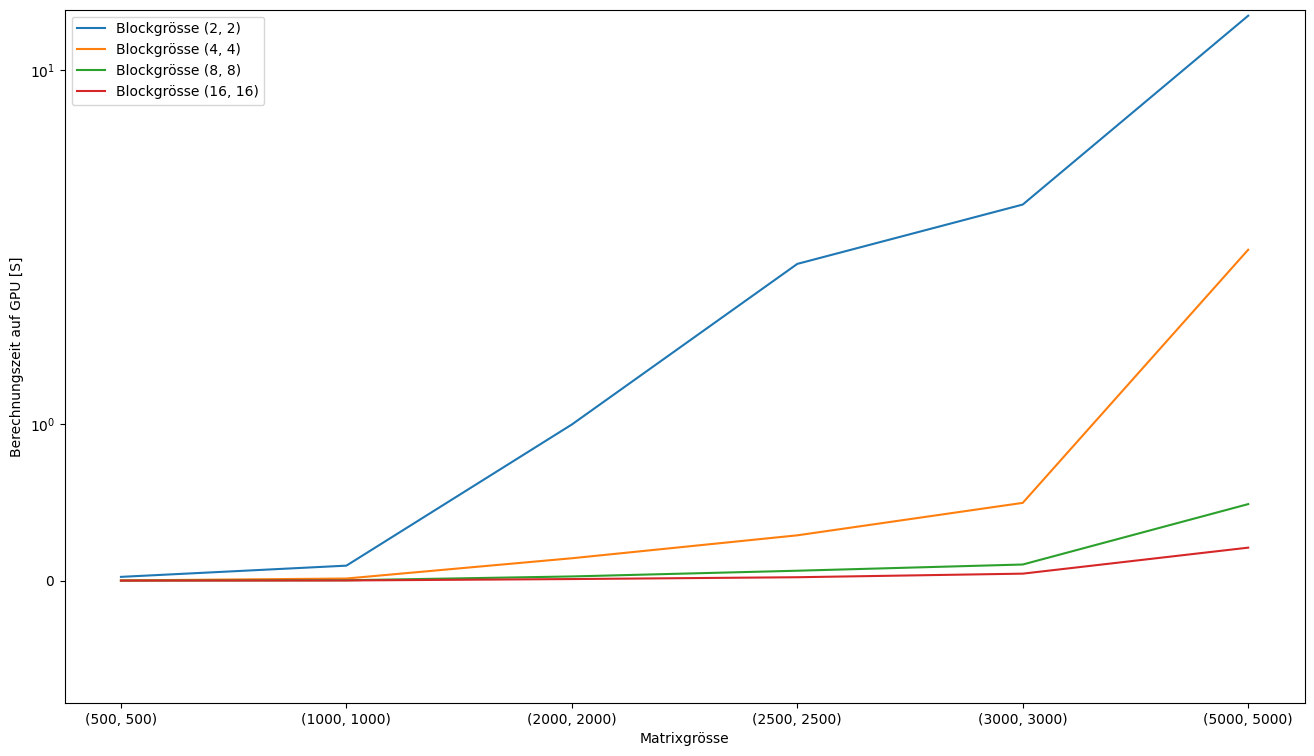

In [ ]:
### BEGIN SOLUTION
fig, ax = plt.subplots()
ax.plot(s2, label=f"Blockgrösse {str((2,2))}")
ax.plot(s4, label=f"Blockgrösse {str((4,4))}")
ax.plot(s8, label=f"Blockgrösse {str((8,8))}")
ax.plot(s16, label=f"Blockgrösse {str((16,16))}")
ax.set_xticks(list(range(6)))
ax.set_xticklabels([str(matrix_size) for matrix_size in [(500, 500), (1000, 1000), (2000, 2000), (2500, 2500), (3000, 3000), (5000, 5000)]])
plt.ylabel("Berechnungszeit auf GPU [S]")
plt.xlabel("Matrixgrösse")
plt.legend()
plt.yscale('symlog')
plt.show()
### END SOLUTION

Was sind deine Erkenntnisse bzgl. GPU-Memory-Allokation und des Daten-Transferes auf die GPU? Interpretiere deine Resultate.

<font color='blue'>Antwort hier eingeben</font>
Je grösser die Blockdimension, desto schneller ist die Rekonstruktion der Matrix. Am besten performate die Blockdimension 16,16.

Ein direkter Vergleich mit der Performance der CPU ist nicht möglich, da unterschiedliche Matrizen verwendet werden. Im ersten Teil der Minichallenge wurde die Matrixrekonstruktion mit maximal 170 Dimensionen durchgeführt. Die kleinste Matrix, die für die Rekonstruktion im GPU-Teil verwendet wurde, hat die Dimension 500,500. Im ersten Teil konnte mit der Parallelisierung durch numba eine Laufzeit von ungefähr 0.02 Sekunden erreicht werden. Die schnellste Blockdimension berechnete die Matrixrekonstruktion in 0.000571 Sekunden. Die Berechnung der SVD-Rekonstruktion ist auf der GPU schneller, wenn es sich um grosse Matrizen handelt.

##### 5.2.3 Bonus: Weitere Optimierungen
Optimiere deine Implementation von oben weiter. Damit du Erfolg hast, muss der Data-Reuse noch grösser sein.

In [ ]:
### BEGIN SOLUTION
### END SOLUTION

#### 5.3 NVIDIA Profiler

Benutze einen Performance Profiler von NVIDIA, um Bottlenecks in deinem Code zu identifizieren bzw. unterschiedliche Implementierungen (Blocks, Memory etc.) zu vergleichen. 

* Siehe Beispiel example_profiling_CUDA.ipynb
* [Nsight](https://developer.nvidia.com/nsight-visual-studio-edition) für das Profiling des Codes und die Inspektion der Ergebnisse (neuste Variante)
* [nvprof](https://docs.nvidia.com/cuda/profiler-users-guide/index.html#nvprof-overview)
* [Nvidia Visual Profiler](https://docs.nvidia.com/cuda/profiler-users-guide/index.html#visual)

> Du kannst NVIDIA Nsights Systems und den Nvidia Visual Profiler auf deinem PC installieren und die Leistungsergebnisse aus einer Remote-Instanz visualisieren, auch wenn du keine GPU an/in deinem PC hast. Dafür kannst du die ``*.qdrep`` Datei generieren und danach lokal laden.


Dokumentiere deine Analyse ggf. mit 1-2 Visualisierungen und beschreibe, welche Bottlenecks du gefunden bzw. entschärft hast.

In [ ]:
!sudo apt-get install cuda-11.8

In [ ]:
import os
os.environ['PATH'] = os.environ['PATH'] + ':/usr/local/cuda-11.8/bin/'

In [ ]:
!find / -iname 'libdevice'
!find / -iname 'libnvvm.so'

/usr/local/lib/python3.10/dist-packages/jaxlib/cuda/nvvm/libdevice
/usr/local/cuda-11.8/nvvm/libdevice
find: ‘/proc/53/task/53/net’: Invalid argument
find: ‘/proc/53/net’: Invalid argument
/usr/local/cuda-11.8/nvvm/lib64/libnvvm.so
find: ‘/proc/53/task/53/net’: Invalid argument
find: ‘/proc/53/net’: Invalid argument


In [ ]:
os.environ['NUMBAPRO_LIBDEVICE'] = "/usr/local/cuda-11.8/nvvm/libdevice"
os.environ['NUMBAPRO_NVVM'] = "/usr/local/cuda-11.8/nvvm/lib64/libnvvm.so"

In [ ]:
with open("test.py", "w") as fp:
    fp.write('''
#!/opt/miniconda3/bin/python

import math
from numba import vectorize, cuda, float32, float64
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16,9)
device = cuda.get_current_device()

@cuda.jit
def svd_reconstruction(u, s, vt, reco):
    """
    Perform SVD reconstruction of the matrix reco = u * s * vt using CUDA shared memory.

    Reference: Replace this with your SVD reconstruction logic
    """
    # define shared memory arrays
    sU = cuda.shared.array(shape=(tbs, tbs), dtype=float32)
    sS = cuda.shared.array(shape=(tbs, tbs), dtype=float32)
    sVT = cuda.shared.array(shape=(tbs, tbs), dtype=float32)

    x, y = cuda.grid(2)

    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    blocks_per_grid = cuda.gridDim.x

    # Each thread computes one element in the result matrix.
    tmp = float32(0.)
    for i in range(blocks_per_grid):
        # load data into shared memory of each block, only accessible by threads in block
        sU[ty, tx] = 0
        sS[ty, tx] = 0
        sVT[ty, tx] = 0

        # check dimensions
        if y < u.shape[0] and (tx + i * tbs) < u.shape[1]:
            sU[ty, tx] = u[y, tx + i * tbs]
        if x < s.shape[1] and (ty + i * tbs) < s.shape[0]:
            sS[ty, tx] = s[ty + i * tbs, x]
        if x < vt.shape[1] and (ty + i * tbs) < vt.shape[0]:
            sVT[ty, tx] = vt[ty + i * tbs, x]

        # wait for all threads in block
        cuda.syncthreads()

        # calc svd reco value
        for j in range(tbs):
            tmp += sU[ty, j] * sS[j, tx] * sVT[j, tx]

        # wait for all threads in block
        cuda.syncthreads()

    # add values to reconstruction matrix
    if y < reco.shape[0] and x < reco.shape[1]:
        reco[y, x] = tmp


def run_svd_reco(tbs):
    # generate matrices
    np.random.seed(42)
    matrices = {}

    matrix_sizes = [(500, 500), (1000, 1000), (2000, 2000), (2500, 2500), (3000, 3000), (5000, 5000)]  #  matrices have to be bigger than kernel size

    stream = cuda.stream()
    times_block_dims = []
    for matrix_size in matrix_sizes:
        with cuda.pinned():
            print("Matrix size: ", matrix_size)
            u_h = np.random.random(matrix_size).astype(np.float32)
            s_h = np.random.random((matrix_size[0], 1)).astype(np.float32)
            vt_h = np.random.random(matrix_size).astype(np.float32)
            reco_h = np.zeros(matrix_size).astype(np.float32)

            with cuda.defer_cleanup():
                start = datetime.now()
                print(f"0: {(datetime.now() - start).total_seconds()}")
                u_d = cuda.to_device(u_h, stream=stream)
                print(f"1: {(datetime.now() - start).total_seconds()}")
                s_d = cuda.to_device(s_h, stream=stream)
                print(f"2: {(datetime.now() - start).total_seconds()}")
                vt_d = cuda.to_device(vt_h, stream=stream)
                print(f"3: {(datetime.now() - start).total_seconds()}")
                reco_d = cuda.to_device(reco_h, stream=stream)
                print(f"4: {(datetime.now() - start).total_seconds()}")
                stream.synchronize()
                end = datetime.now()

        print("Transfer Time [s]: ", (end - start).total_seconds())

        blockspergrid_x = math.ceil(reco_h.shape[0] / tbs)
        blockspergrid_y = math.ceil(reco_h.shape[1] / tbs)
        blockspergrid = (blockspergrid_x, blockspergrid_y)
        times = []
        for i in range(10):
            start = datetime.now()
            svd_reconstruction[blockspergrid, (tbs, tbs), stream, 0](u_d, s_d, vt_d, reco_d)
            stream.synchronize()
            process_time_gpu = (datetime.now() - start).total_seconds()
            print(f"kernel: {process_time_gpu}")
            times.append(process_time_gpu)

        times_block_dims.append(np.median(times))

        del u_d, u_h
        del s_d, s_h
        del vt_d, vt_h
        del reco_d, reco_h
        stream.synchronize()

    return times_block_dims

tbs = 16
run_svd_reco(16)
''')

In [ ]:
!ncu -f -o svd_reconstruction --set full --target-processes all python test.py

In [ ]:
with open("test2.py", "w") as fp:
    fp.write("""
#!/opt/miniconda3/bin/python

import math
from numba import vectorize, cuda, float32, float64
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16,9)
device = cuda.get_current_device()

### BEGIN SOLUTION
@cuda.jit
def svd_reconstruction(u, s, vt, reco):
    i, j = cuda.grid(2)

    if i < u.shape[0] and j < vt.shape[1]:
        tmp = 0.
        for m in range(u.shape[1]):
            tmp += u[i, m] * s[m, 0] * vt[m, j]
        reco[i, j] = tmp

# generate matrices
np.random.seed(42)
matrices = {}

matrix_sizes = [(500, 500), (1000, 1000), (2000, 2000), (2500, 2500), (3000, 3000), (5000, 5000)]  #  matrices have to be bigger than kernel size

thread_sizes = [(16, 16)]

times_matrix_sizes, std_matrix_sizes = [], []
stream = cuda.stream()

for matrix_size in matrix_sizes:
    with cuda.pinned():
        print("Matrix size: ", matrix_size)
        u_h = np.random.random(matrix_size).astype(np.float32)
        s_h = np.random.random((matrix_size[0], 1)).astype(np.float32)
        vt_h = np.random.random(matrix_size).astype(np.float32)
        reco_h = np.zeros(matrix_size).astype(np.float32)

        with cuda.defer_cleanup():
            start = datetime.now()
            print(f"0: {(datetime.now() - start).total_seconds()}")
            u_d = cuda.to_device(u_h, stream=stream)
            print(f"1: {(datetime.now() - start).total_seconds()}")
            s_d = cuda.to_device(s_h, stream=stream)
            print(f"2: {(datetime.now() - start).total_seconds()}")
            vt_d = cuda.to_device(vt_h, stream=stream)
            print(f"3: {(datetime.now() - start).total_seconds()}")
            reco_d = cuda.to_device(reco_h, stream=stream)
            print(f"4: {(datetime.now() - start).total_seconds()}")
            stream.synchronize()
            end = datetime.now()

    print("Transfer Time [s]: ", (end - start).total_seconds())

    times_thread_sizes, std_thread_sizes = [], []

    for thread_size in thread_sizes:
        print("Thread size: ", thread_size)
        blockspergrid_x = math.ceil(reco_h.shape[0] / thread_size[0])
        blockspergrid_y = math.ceil(reco_h.shape[1] / thread_size[1])
        blockspergrid = (blockspergrid_x, blockspergrid_y)
        times = []
        for i in range(5):
            start = datetime.now()
            svd_reconstruction[blockspergrid, thread_size, stream, 0](u_d, s_d, vt_d, reco_d)
            stream.synchronize()
            process_time_gpu = (datetime.now() - start).total_seconds()
            print(f"kernel: {process_time_gpu}")
            times.append(process_time_gpu)

        times_thread_sizes.append(np.median(times)), std_thread_sizes.append(np.std(times))

    times_matrix_sizes.append(times_thread_sizes), std_matrix_sizes.append(std_thread_sizes)

    del u_d, u_h
    del s_d, s_h
    del vt_d, vt_h
    del reco_d, reco_h

### END SOLUTION
    """)


In [ ]:
!ncu -f -o svd_reconstruction --set full --target-processes all python test2.py

==PROF== Target process 37741 terminated before first instrumented API call.
==PROF== Connected to process 37740 (/usr/bin/python3.10)
Matrix size:  (500, 500)
0: 6e-06
1: 0.001471
2: 0.002109
3: 0.003078
4: 0.004068
Transfer Time [s]:  0.004183
Thread size:  (16, 16)
==PROF== Profiling "v1,cw51cXTLSUwHBinCqbbgUAAGBl..." - 0: 0%....50%....100% - 31 passes
kernel: 1.64952
==PROF== Profiling "v1,cw51cXTLSUwHBinCqbbgUAAGBl..." - 1: 0%....50%....100% - 31 passes
kernel: 0.765675
==PROF== Profiling "v1,cw51cXTLSUwHBinCqbbgUAAGBl..." - 2: 0%....50%....100% - 31 passes
kernel: 0.752352
==PROF== Profiling "v1,cw51cXTLSUwHBinCqbbgUAAGBl..." - 3: 0%....50%....100% - 31 passes
kernel: 0.753744
==PROF== Profiling "v1,cw51cXTLSUwHBinCqbbgUAAGBl..." - 4: 0%....50%....100% - 31 passes
kernel: 0.755599
Matrix size:  (1000, 1000)
0: 6e-06
1: 0.001986
2: 0.002628
3: 0.004211
4: 0.005903
Transfer Time [s]:  0.005949
Thread size:  (16, 16)
==PROF== Profiling "v1,cw51cXTLSUwHBinCqbbgUAAGBl..." - 5: 0%....5

<font color='blue'>Antwort hier eingeben inkl. Bild.</font>

Die Evaluierung wurde nur für die Blockgrösse 16,16 durchgeführt. Die SVD-Rekonstruktion wurde für folgende Matrizengrössen durchgeführt:
* 500,500
* 1000,1000
* 2000, 2000
* 2500, 2500
* 3000, 3000
* 5000, 5000

Mit Nsight Compute konnten folgende Beobachtungen gemacht werden:

### GPU Throughput
<img src="images/shared%20memory%20GPU%20throughput.png">

Die Auslastung des Shared Memorys und des Memorys ist mit über 90% relativ hoch und kann nicht weiter verbessert werden. 

### Warp State Statistics

<img src="images/warp%20state%20statistics.png">

Durch die Benutzung des Shared Memorys wird relativ viel Zeit zwischen den Warps mit Warten verbracht, bis der nächste Warp durchgeführt werden kann. Mehr als die Hälfte der Zeit wird dabei für Memory Input/Output Operationen (MIO) verbraucht. Dies liegt an der Verwendung des Shared Memorys. Um diese Wartezeit zu vermindern, schlägt Nsight Compute vor, weniger, dafür grössere Blöcke zu verwenden. 

### Memory Overview

<img src="images/shared%20memory%20memory%20overview.png">

Das Memory Access Pattern zwischen dem L1TEX und L2 ist nicht optimal. Durch die relativ kleine Blockgrösse werden die Caches nicht optimal ausgenutzt. Eine grössere Blockgrösse könnte in einer besseren Performance resultieren. 

<font color='blue'>Antwort hier eingeben inkl. Bild.</font>

### 6 Beschleunigte Rekonstruktion mehrerer Bilder
#### 6.1 Implementierung
Verwende einige der in bisher gelernten Konzepte, um mehrere Bilder gleichzeitig parallel zu rekonstruieren. Weshalb hast du welche Konzepte für deine Implementierung verwenden? Versuche die GPU konstant auszulasten und so auch die verschiedenen Engines der GPU parallel zu brauchen. Untersuche dies auch für grössere Inputs als die MRI-Bilder.

In [ ]:
@cuda.jit
def svd_reconstruction(u, s, vt, reco):
    """
    Perform SVD reconstruction of the matrix reco = u * s * vt using CUDA shared memory.

    Reference: Replace this with your SVD reconstruction logic
    """
    # define shared memory arrays
    sU = cuda.shared.array(shape=(32, 32), dtype=float32)
    sS = cuda.shared.array(shape=(32, 32), dtype=float32)
    sVT = cuda.shared.array(shape=(32, 32), dtype=float32)

    x, y = cuda.grid(2)

    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    bx = cuda.blockIdx.x
    by = cuda.blockIdx.y
    bw = cuda.blockDim.x
    bh = cuda.blockDim.y

    # Each thread computes one element in the result matrix.
    tmp = 0.0
    for i in range(u.shape[1] // 32):
        # load data into shared memory of each block, only accessible by threads in the block
        sU[ty, tx] = 0.0
        sS[ty, tx] = 0.0
        sVT[ty, tx] = 0.0

        # check dimensions
        if y < u.shape[0] and (tx + i * 32) < u.shape[1]:
            sU[ty, tx] = u[y, tx + i * 32]
        if x < s.shape[1] and (ty + i * 32) < s.shape[0]:
            sS[ty, tx] = s[ty + i * 32, x]
        if x < vt.shape[1] and (ty + i * 32) < vt.shape[0]:
            sVT[ty, tx] = vt[ty + i * 32, x]

        # wait for all threads in the block
        cuda.syncthreads()

        # calculate SVD reconstruction value
        for j in range(32):
            tmp += sU[ty, j] * sS[j, tx] * sVT[j, tx]

        # wait for all threads in the block
        cuda.syncthreads()

    # add values to the reconstruction matrix
    if y < reco.shape[0] and x < reco.shape[1]:
        reco[y, x] = tmp

def run_svd_reco(n_images):
    # generate matrices
    np.random.seed(42)
    matrices = {}

    transfer_start_times, transfer_total_times = [], []
    calculation_start_times, calculation_total_times = [], []

    matrix_size = (5000, 5000)

    for i in range(n_images):
        stream = cuda.stream()
        times_block_dims = []
        with cuda.pinned():
            print("Matrix size: ", matrix_size)
            u_h = np.random.random(matrix_size).astype(np.float32)
            s_h = np.random.random((matrix_size[0], 1)).astype(np.float32)
            vt_h = np.random.random(matrix_size).astype(np.float32)
            reco_h = np.zeros(matrix_size).astype(np.float32)

            with cuda.defer_cleanup():
                start = datetime.now()
                print(f"0: {(datetime.now() - start).total_seconds()}")
                u_d = cuda.to_device(u_h, stream=stream)
                print(f"1: {(datetime.now() - start).total_seconds()}")
                s_d = cuda.to_device(s_h, stream=stream)
                print(f"2: {(datetime.now() - start).total_seconds()}")
                vt_d = cuda.to_device(vt_h, stream=stream)
                print(f"3: {(datetime.now() - start).total_seconds()}")
                reco_d = cuda.to_device(reco_h, stream=stream)
                print(f"4: {(datetime.now() - start).total_seconds()}")
                stream.synchronize()
                end = datetime.now()

            transfer_start_times.append(start.timestamp()), transfer_total_times.append((end - start).total_seconds())

        print("Transfer Time [s]: ", (end - start).total_seconds())

        blockspergrid_x = math.ceil(reco_h.shape[0] / 32)
        blockspergrid_y = math.ceil(reco_h.shape[1] / 32)
        blockspergrid = (blockspergrid_x, blockspergrid_y)
        times = []

        start = datetime.now()
        svd_reconstruction[blockspergrid, (32, 32), stream](u_d, s_d, vt_d, reco_d)
        stream.synchronize()
        end = datetime.now()
        calculation_start_times.append(start.timestamp()), calculation_total_times.append((end - start).total_seconds())
        process_time_gpu = (datetime.now() - start).total_seconds()
        print(f"kernel: {process_time_gpu}")

        del u_d, u_h
        del s_d, s_h
        del vt_d, vt_h
        del reco_d, reco_h
        stream.synchronize()

    return transfer_start_times, transfer_total_times, calculation_start_times, calculation_total_times

transfer_start_times, transfer_total_times, calculation_start_times, calculation_total_times = run_svd_reco(10)

Matrix size:  (5000, 5000)
0: 7e-06
1: 0.023482
2: 0.024664
3: 0.04634
4: 0.068194
Transfer Time [s]:  0.06878
kernel: 2.885993
Matrix size:  (5000, 5000)
0: 6e-06
1: 0.022572
2: 0.023713
3: 0.044955
4: 0.066091
Transfer Time [s]:  0.066178
kernel: 2.452229
Matrix size:  (5000, 5000)
0: 5e-06
1: 0.022229
2: 0.023326
3: 0.044969
4: 0.066585
Transfer Time [s]:  0.067123
kernel: 2.452388
Matrix size:  (5000, 5000)
0: 6e-06
1: 0.022308
2: 0.023443
3: 0.045344
4: 0.067102
Transfer Time [s]:  0.067648
kernel: 2.451512
Matrix size:  (5000, 5000)
0: 5e-06
1: 0.022204
2: 0.023149
3: 0.044725
4: 0.0668
Transfer Time [s]:  0.067381
kernel: 2.4514
Matrix size:  (5000, 5000)
0: 6e-06
1: 0.022448
2: 0.0236
3: 0.045428
4: 0.066858
Transfer Time [s]:  0.067359
kernel: 2.452152
Matrix size:  (5000, 5000)
0: 5e-06
1: 0.022813
2: 0.023989
3: 0.045917
4: 0.067639
Transfer Time [s]:  0.068139
kernel: 2.452197
Matrix size:  (5000, 5000)
0: 6e-06
1: 0.025569
2: 0.027986
3: 0.051703
4: 0.080026
Transfer Time 

Total time:  30.88


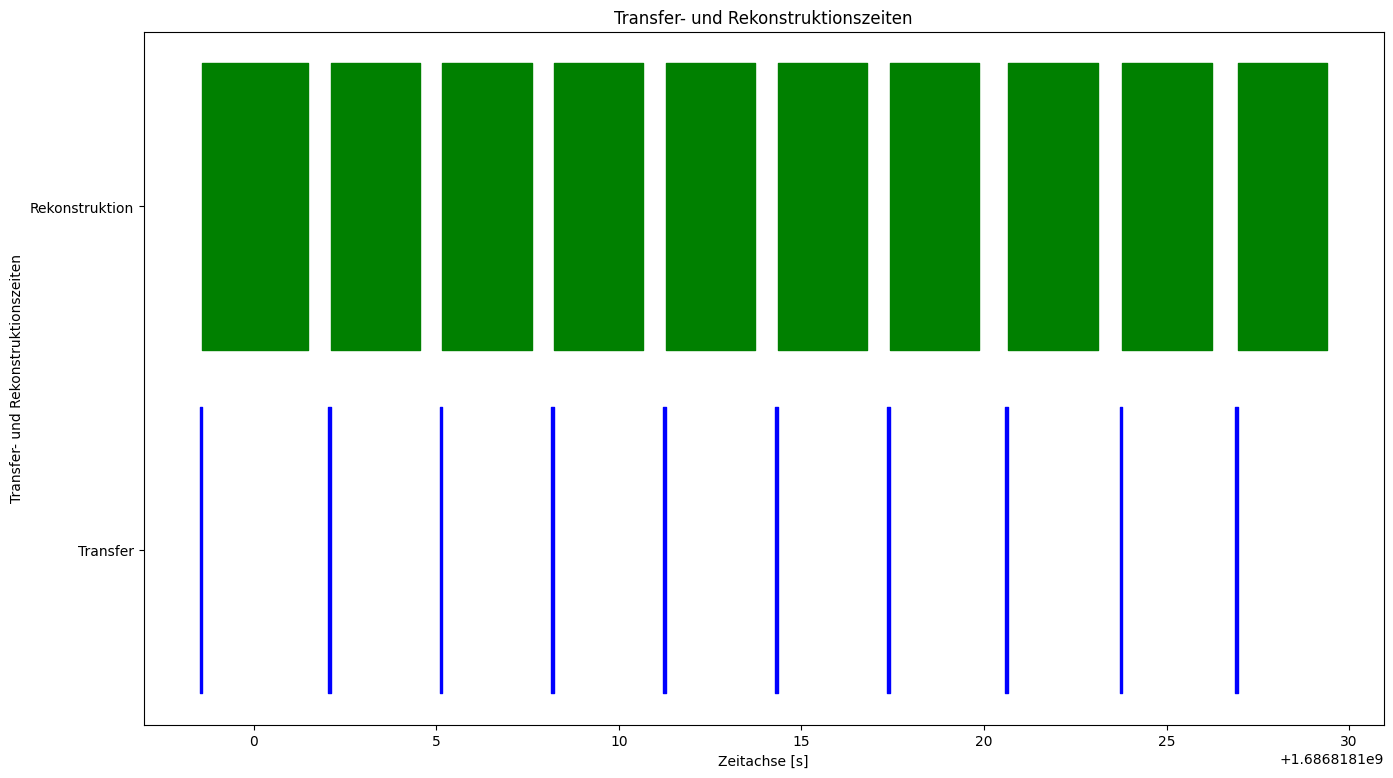

In [ ]:
print("Total time: ", np.round(calculation_start_times[-1] + calculation_total_times[-1] - transfer_start_times[0], 2))
plt.broken_barh(list(zip(transfer_start_times, transfer_total_times)), (0,1), color='blue')
plt.broken_barh(list(zip(calculation_start_times, calculation_total_times)), (1.2,1), color='green')
plt.xlabel("Zeitachse [s]")
plt.ylabel("Transfer- und Rekonstruktionszeiten")
plt.yticks([0.5, 1.7], ["Transfer", "Rekonstruktion"])
plt.yticks()
plt.title("Transfer- und Rekonstruktionszeiten")
plt.show()

#### Implementierung mit Multiprocessing

In [ ]:
@cuda.jit
def svd_reconstruction(u, s, vt, reco):
    """
    Perform SVD reconstruction of the matrix reco = u * s * vt using CUDA shared memory.

    Reference: Replace this with your SVD reconstruction logic
    """
    # define shared memory arrays
    sU = cuda.shared.array(shape=(32, 32), dtype=float32)
    sS = cuda.shared.array(shape=(32, 32), dtype=float32)
    sVT = cuda.shared.array(shape=(32, 32), dtype=float32)

    x, y = cuda.grid(2)

    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    bx = cuda.blockIdx.x
    by = cuda.blockIdx.y
    bw = cuda.blockDim.x
    bh = cuda.blockDim.y

    # Each thread computes one element in the result matrix.
    tmp = 0.0
    for i in range(u.shape[1] // 32):
        # load data into shared memory of each block, only accessible by threads in the block
        sU[ty, tx] = 0.0
        sS[ty, tx] = 0.0
        sVT[ty, tx] = 0.0

        # check dimensions
        if y < u.shape[0] and (tx + i * 32) < u.shape[1]:
            sU[ty, tx] = u[y, tx + i * 32]
        if x < s.shape[1] and (ty + i * 32) < s.shape[0]:
            sS[ty, tx] = s[ty + i * 32, x]
        if x < vt.shape[1] and (ty + i * 32) < vt.shape[0]:
            sVT[ty, tx] = vt[ty + i * 32, x]

        # wait for all threads in the block
        cuda.syncthreads()

        # calculate SVD reconstruction value
        for j in range(32):
            tmp += sU[ty, j] * sS[j, tx] * sVT[j, tx]

        # wait for all threads in the block
        cuda.syncthreads()

    # add values to the reconstruction matrix
    if y < reco.shape[0] and x < reco.shape[1]:
        reco[y, x] = tmp

def reconstruct_images(images, num_processes):
    ctx = mp.get_context('spawn')
    manager = mp.Manager()
    input_queue = manager.Queue()
    reconstruction_queue = manager.Queue()
    transfer_times = manager.list()
    reconstruction_times = manager.list()

    for image in images:
        input_queue.put(image)

    for n in range(num_processes):
        input_queue.put(None)

    processes = []

    for _ in range(num_processes):
        p = ctx.Process(target=reconstruct_image, args=[input_queue, reconstruction_queue, transfer_times, reconstruction_times])
        p.start()
        processes.append(p)

    for p in processes:
        p.join()

    return list(transfer_times), list(reconstruction_times)

def reconstruct_image(input_queue, reconstruction_queues, transfer_times, reconstruction_times):
    stream = cuda.stream()

    while True:
        image = input_queue.get()
        if image is None:
            break

        (u_h, s_h, vt_h, reco_h) = image
        blockspergrid_x = math.ceil(reco_h.shape[0] / 32)
        blockspergrid_y = math.ceil(reco_h.shape[1] / 32)
        blockspergrid = (blockspergrid_x, blockspergrid_y)
        with cuda.pinned(u_h, s_h, vt_h, reco_h):
            start = datetime.now()
            u_d = cuda.to_device(u_h, stream=stream)
            s_d = cuda.to_device(s_h, stream=stream)
            vt_d = cuda.to_device(vt_h, stream=stream)
            reco_d = cuda.to_device(reco_h, stream=stream)
            end = datetime.now()

            transfer_times.append((start.timestamp(), (end - start).total_seconds()))
            start = datetime.now()
            svd_reconstruction[blockspergrid, (32, 32), stream](u_d, s_d, vt_d, reco_d)
            end = datetime.now()

            reconstruction_times.append((start.timestamp(), (end - start).total_seconds()))

            reco_h = reco_d.copy_to_host()
            reconstruction_queue.put(reco_h)

            del u_d, u_h
            del s_d, s_h
            del vt_d, vt_h
            del reco_d, reco_h

    sys.stdout.flush()

def test_parallel_reconstruction(n_images):
    np.random.seed(42)
    matrices = []

    matrix_size = (5000, 5000)

    for _ in range(n_images):
        u_h = np.random.random(matrix_size).astype(np.float32)
        s_h = np.random.random((matrix_size[0], 1)).astype(np.float32)
        vt_h = np.random.random(matrix_size).astype(np.float32)
        reco_h = np.random.random(matrix_size).astype(np.float32)

        matrices.append((u_h, s_h, vt_h, reco_h))

    transfer_times, reconstruction_times = reconstruct_images(matrices, 1)
    return transfer_times, reconstruction_times

test_parallel_reconstruction(10)

([], [])

#### Implementierung mit Multi-Threading, alle Bilder parallel

In [ ]:
import threading
import numpy as np
import math
import sys
from numba import cuda
from datetime import datetime

@cuda.jit
def svd_reconstruction(u, s, vt, reco):
    """
    Perform SVD reconstruction of the matrix reco = u * s * vt using CUDA shared memory.

    Reference: Replace this with your SVD reconstruction logic
    """
    # define shared memory arrays
    sU = cuda.shared.array(shape=(32, 32), dtype=float32)
    sS = cuda.shared.array(shape=(32, 32), dtype=float32)
    sVT = cuda.shared.array(shape=(32, 32), dtype=float32)

    x, y = cuda.grid(2)

    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    bx = cuda.blockIdx.x
    by = cuda.blockIdx.y
    bw = cuda.blockDim.x
    bh = cuda.blockDim.y

    # Each thread computes one element in the result matrix.
    tmp = 0.0
    for i in range(u.shape[1] // 32):
        # load data into shared memory of each block, only accessible by threads in the block
        sU[ty, tx] = 0.0
        sS[ty, tx] = 0.0
        sVT[ty, tx] = 0.0

        # check dimensions
        if y < u.shape[0] and (tx + i * 32) < u.shape[1]:
            sU[ty, tx] = u[y, tx + i * 32]
        if x < s.shape[1] and (ty + i * 32) < s.shape[0]:
            sS[ty, tx] = s[ty + i * 32, x]
        if x < vt.shape[1] and (ty + i * 32) < vt.shape[0]:
            sVT[ty, tx] = vt[ty + i * 32, x]

        # wait for all threads in the block
        cuda.syncthreads()

        # calculate SVD reconstruction value
        for j in range(32):
            tmp += sU[ty, j] * sS[j, tx] * sVT[j, tx]

        # wait for all threads in the block
        cuda.syncthreads()

    # add values to the reconstruction matrix
    if y < reco.shape[0] and x < reco.shape[1]:
        reco[y, x] = tmp


def reconstruct_images(images, num_threads):
    transfer_times = []
    reconstruction_times = []

    def reconstruct_image(image, reconstruction_queue):
        stream = cuda.stream()
        (u_h, s_h, vt_h, reco_h) = image
        blockspergrid_x = math.ceil(reco_h.shape[0] / 32)
        blockspergrid_y = math.ceil(reco_h.shape[1] / 32)
        blockspergrid = (blockspergrid_x, blockspergrid_y)
        with cuda.pinned(u_h, s_h, vt_h, reco_h):
            start = datetime.now()
            u_d = cuda.to_device(u_h, stream=stream)
            s_d = cuda.to_device(s_h, stream=stream)
            vt_d = cuda.to_device(vt_h, stream=stream)
            reco_d = cuda.to_device(reco_h, stream=stream)
            end = datetime.now()

            transfer_times.append((start.timestamp(), (end - start).total_seconds()))
            start = datetime.now()
            svd_reconstruction[blockspergrid, (32, 32), stream](u_d, s_d, vt_d, reco_d)
            end = datetime.now()

            reconstruction_times.append((start.timestamp(), (end - start).total_seconds()))

            reco_h = reco_d.copy_to_host(stream=stream)
            stream.synchronize()

            reconstruction_queue.append(reco_h)

            del u_d, u_h
            del s_d, s_h
            del vt_d, vt_h
            del reco_d, reco_h

        sys.stdout.flush()

    input_queue = images.copy()
    reconstruction_queue = []

    for _ in range(num_threads):
        reconstruction_queue.append([])

    thread_lock = threading.Lock()

    def process_image():
        while True:
            with thread_lock:
                if len(input_queue) == 0:
                    break
                image = input_queue.pop(0)
                thread_id = threading.get_ident() % num_threads

            reconstruction_queue[thread_id] = []
            reconstruct_image(image, reconstruction_queue[thread_id])

    threads = []
    for _ in range(num_threads):
        t = threading.Thread(target=process_image)
        t.start()
        threads.append(t)

    for t in threads:
        t.join()

    reconstructed_images = []
    for queue in reconstruction_queue:
        reconstructed_images.extend(queue)

    return transfer_times, reconstruction_times


def test_parallel_reconstruction(n_images):
    np.random.seed(42)
    matrices = []

    matrix_size = (5000, 5000)

    for _ in range(n_images):
        u_h = np.random.random(matrix_size).astype(np.float32)
        s_h = np.random.random((matrix_size[0], 1)).astype(np.float32)
        vt_h = np.random.random(matrix_size).astype(np.float32)
        reco_h = np.random.random(matrix_size).astype(np.float32)

        matrices.append((u_h, s_h, vt_h, reco_h))

    transfer_times, reconstruction_times = reconstruct_images(matrices, n_images)
    return transfer_times, reconstruction_times


transfer_times, reconstruction_times = test_parallel_reconstruction(10)


In [ ]:
def visualize_times2(transfer_times, reconstruction_times):
    print("Total time: ", np.round(reconstruction_times[-1][0] + reconstruction_times[-1][1] - transfer_times[0][0], 2))
    fig, ax = plt.subplots()

    for i, (transfer_time, reconstruction_time) in enumerate(zip(transfer_times, reconstruction_times)):
        ax.broken_barh([transfer_time], [i, 0.4], color='blue', label='Transfer')
        ax.broken_barh([reconstruction_time], [i + 0.5, 0.4], color='green', label='GPU')


    ax.legend(['Transfer', 'GPU'], loc='lower right')
    ax.set_title("Vergleich Transfer- und Rekonstruktionszeiten")
    ax.set_ylabel("Bild-Index")
    ax.set_xlabel("Zeit [s]")
    ax.set_yticks([index - 0.5 for index in list(range(1, i+2))], labels=["Bild " + str(index) for index in range(1, i+2)])
    plt.show()

Total time:  22.89


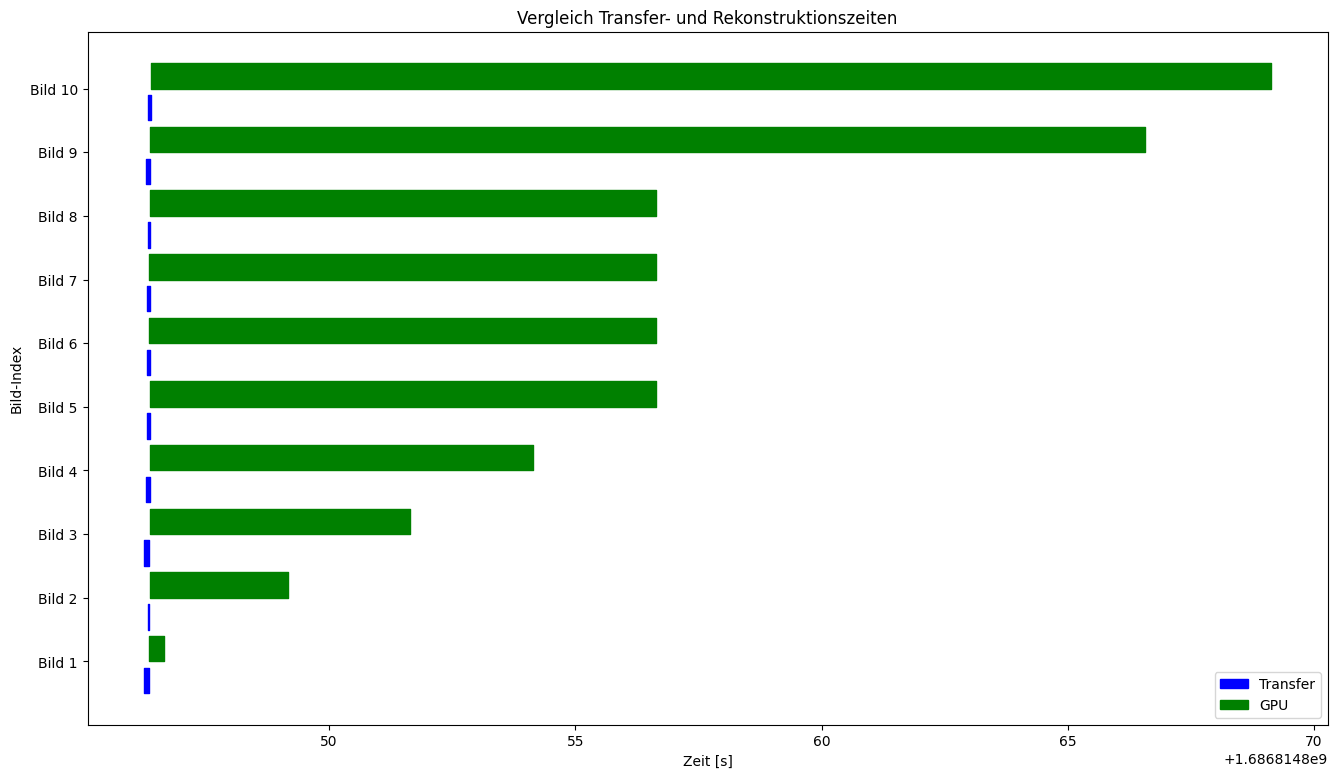

In [ ]:
print("Total time: ", np.round(reconstruction_times[-1][0] + reconstruction_times[-1][1] - transfer_times[0][0], 2))
fig, ax = plt.subplots()

for i, (transfer_time, reconstruction_time) in enumerate(zip(transfer_times, reconstruction_times)):
    ax.broken_barh([transfer_time], [i, 0.4], color='blue', label='Transfer')
    ax.broken_barh([reconstruction_time], [i + 0.5, 0.4], color='green', label='GPU')


ax.legend(['Transfer', 'GPU'], loc='lower right')
ax.set_title("Vergleich Transfer- und Rekonstruktionszeiten")
ax.set_ylabel("Bild-Index")
ax.set_xlabel("Zeit [s]")
ax.set_yticks([index - 0.5 for index in list(range(1, i+2))], labels=["Bild " + str(index) for index in range(1, i+2)])
plt.show()

Diese Variante startet alle Threads gleichzeitig und schickt alle Bilder sofort auf die GPU. Da die GPU nicht alle Bilder gleichzeitig Rekonstruieren kann, gibt es eine unterschiedliche Priorisierung und die Bilder werden nacheinander abgearbeitet. Diese Methode würde natürlich nicht für eine grössere Menge Bilder funktionieren, da der GPU Speicher irgendwann ausgelastet werden würde.

#### Implementierung Multithreading mit Queue

In [ ]:
import threading
import numpy as np
import math
import sys
from numba import cuda
from datetime import datetime

@cuda.jit
def svd_reconstruction(u, s, vt, reco):
    """
    Perform SVD reconstruction of the matrix reco = u * s * vt using CUDA shared memory.

    Reference: Replace this with your SVD reconstruction logic
    """
    # define shared memory arrays
    sU = cuda.shared.array(shape=(32, 32), dtype=float32)
    sS = cuda.shared.array(shape=(32, 32), dtype=float32)
    sVT = cuda.shared.array(shape=(32, 32), dtype=float32)

    x, y = cuda.grid(2)

    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    bx = cuda.blockIdx.x
    by = cuda.blockIdx.y
    bw = cuda.blockDim.x
    bh = cuda.blockDim.y

    # Each thread computes one element in the result matrix.
    tmp = 0.0
    for i in range(u.shape[1] // 32):
        # load data into shared memory of each block, only accessible by threads in the block
        sU[ty, tx] = 0.0
        sS[ty, tx] = 0.0
        sVT[ty, tx] = 0.0

        # check dimensions
        if y < u.shape[0] and (tx + i * 32) < u.shape[1]:
            sU[ty, tx] = u[y, tx + i * 32]
        if x < s.shape[1] and (ty + i * 32) < s.shape[0]:
            sS[ty, tx] = s[ty + i * 32, x]
        if x < vt.shape[1] and (ty + i * 32) < vt.shape[0]:
            sVT[ty, tx] = vt[ty + i * 32, x]

        # wait for all threads in the block
        cuda.syncthreads()

        # calculate SVD reconstruction value
        for j in range(32):
            tmp += sU[ty, j] * sS[j, tx] * sVT[j, tx]

        # wait for all threads in the block
        cuda.syncthreads()

    # add values to the reconstruction matrix
    if y < reco.shape[0] and x < reco.shape[1]:
        reco[y, x] = tmp


def reconstruct_images(images, max_images_on_gpu):
    transfer_times = []
    reconstruction_times = []

    def reconstruct_image(image, reconstruction_queue):
        stream = cuda.stream()
        (u_h, s_h, vt_h, reco_h) = image
        blockspergrid_x = math.ceil(reco_h.shape[0] / 32)
        blockspergrid_y = math.ceil(reco_h.shape[1] / 32)
        blockspergrid = (blockspergrid_x, blockspergrid_y)
        with cuda.pinned(u_h, s_h, vt_h, reco_h):
            start = datetime.now()
            u_d = cuda.to_device(u_h, stream=stream)
            s_d = cuda.to_device(s_h, stream=stream)
            vt_d = cuda.to_device(vt_h, stream=stream)
            reco_d = cuda.to_device(reco_h, stream=stream)
            end = datetime.now()

            transfer_times.append((start.timestamp(), (end - start).total_seconds()))
            start = datetime.now()
            svd_reconstruction[blockspergrid, (32, 32), stream](u_d, s_d, vt_d, reco_d)
            end = datetime.now()

            reconstruction_times.append((start.timestamp(), (end - start).total_seconds()))

            reco_h = reco_d.copy_to_host(stream=stream)
            stream.synchronize()

            reconstruction_queue.append(reco_h)

            del u_d, u_h
            del s_d, s_h
            del vt_d, vt_h
            del reco_d, reco_h

        sys.stdout.flush()

    input_queue = images.copy()
    reconstruction_queue = []

    num_threads = min(max_images_on_gpu, len(input_queue))

    for _ in range(num_threads):
        reconstruction_queue.append([])

    thread_lock = threading.Lock()

    def process_image():
        while True:
            with thread_lock:
                if len(input_queue) == 0:
                    break
                image = input_queue.pop(0)
                thread_id = threading.get_ident() % num_threads

            reconstruction_queue[thread_id] = []
            reconstruct_image(image, reconstruction_queue[thread_id])

    threads = []
    for _ in range(num_threads):
        t = threading.Thread(target=process_image)
        t.start()
        threads.append(t)

    for t in threads:
        t.join()

    reconstructed_images = []
    for queue in reconstruction_queue:
        reconstructed_images.extend(queue)

    return transfer_times, reconstruction_times


def test_parallel_reconstruction(n_images, max_images_on_gpu):
    np.random.seed(42)
    matrices = []

    matrix_size = (5000, 5000)

    for _ in range(n_images):
        u_h = np.random.random(matrix_size).astype(np.float32)
        s_h = np.random.random((matrix_size[0], 1)).astype(np.float32)
        vt_h = np.random.random(matrix_size).astype(np.float32)
        reco_h = np.random.random(matrix_size).astype(np.float32)

        matrices.append((u_h, s_h, vt_h, reco_h))

    transfer_times, reconstruction_times = reconstruct_images(matrices, max_images_on_gpu)
    return transfer_times, reconstruction_times


transfer_times, reconstruction_times = test_parallel_reconstruction(10, 4)

Total time:  20.57


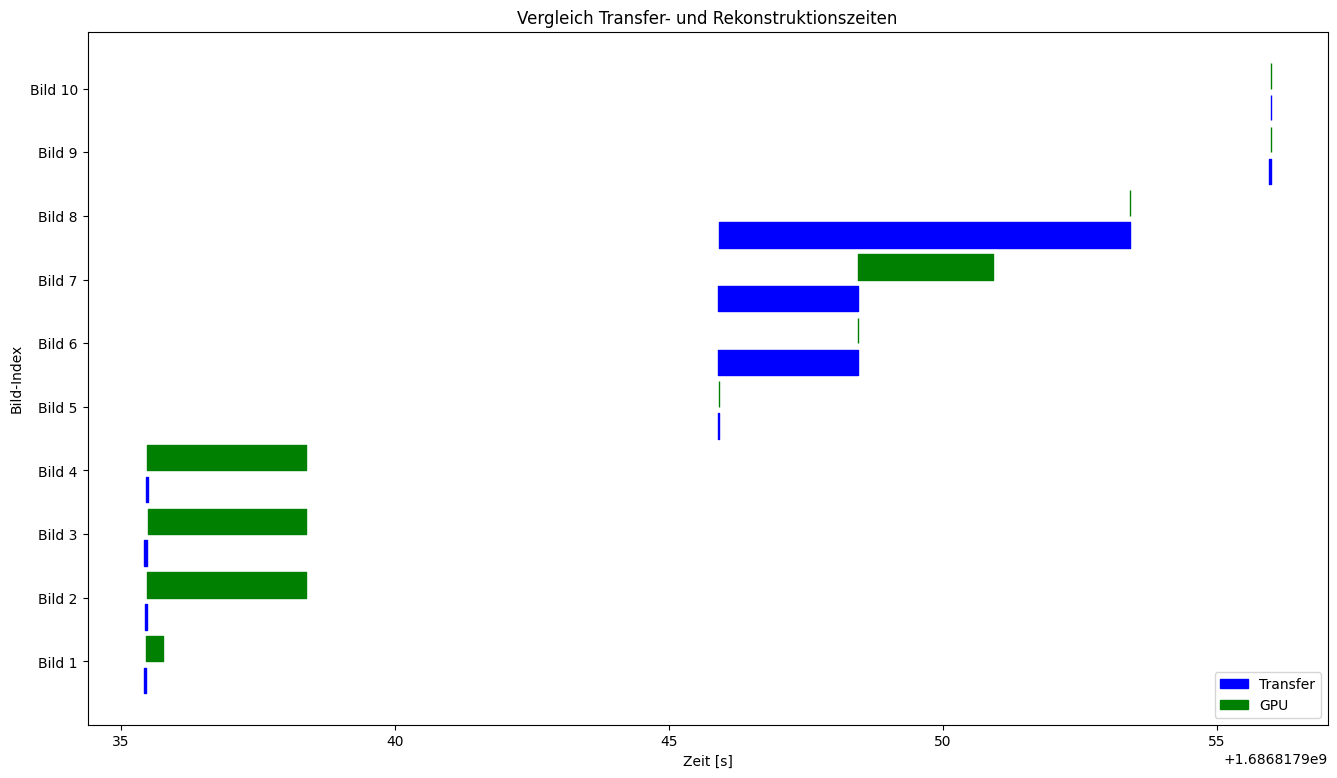

In [ ]:
visualize_times2(transfer_times, reconstruction_times)

Diese Methode ist gesamthaft ca. 2 Sekunden schneller. Die Zeitmessung funktioniert jedoch nicht mehr wie gewünscht. Eine weitere Verbesserung ist jedoch nicht möglich, ohne die Rekonstruktion effizienter zu schreiben. Ein Grossteil der Zeit wird mit der Rekonstruktion der Bilder verbracht und die GPU kann nicht effizient mehrere Bilder parallel rekonstruieren. Das Kernel benötigte bei der seriellen Ausführung ca. 2-2.5s pro Bild. Deshalb ist nicht zu erwarten, dass die Parallelisierung unter 20 Sekunden kommt.

#### 6.2 Analyse
Vergleiche den Speedup für deine parallele Implementierung im Vergleich zur seriellen Rekonstruktion einzelner Bilder. Analysiere und diskutiere in diesem Zusammenhang die Gesetze von Amdahl und Gustafson.

<font color='blue'>Antwort hier eingeben</font>

Amdahls Gesetz:
Das Gesetz besagt, dass die maximale Beschleunigung, die durch die Parallelisierung eines Programms erreicht werden kann, durch den Anteil der Ausführungszeit des Programms begrenzt ist, der sequentiell ist.

Fast alle Teile dieser Aufgabe sind parallelisierbar. Der Datentransfer von Host zu Device und zurück kann parallel in mehreren Streams durchgeführt werden. Die Rekonstruktion der Bilder wird ebenfalls auf mehreren Threads gleichzeitig ausgeführt. Das Limit liegt beim Speicher und der Rechenleistung der GPU. Je grösser der Speicher und die Rechenleistung der GPU, desto mehr Bilder können parallel rekonstruiert werden, desto schneller ist der Code.

Die einzige serielle Aufgabe ist die Erzeugung der Bilder mit der Zufallsfunktion auf der CPU. Dieser Zeitaufwand bleibt fix.

#### 6.3 Komponentendiagramm

Erstelle das Komponentendiagramm dieser Mini-Challenge für die Rekunstruktion mehrere Bilder mit einer GPU-Implementierung. Erläutere das Komponentendigramm in 3-4 Sätzen.


<font color='blue'>Antwort hier eingeben inkl. Bild(ern).</font>
Das Komponentendiagramm zeigt wie die verschiedenen Prozesse mit CPU, RAM und GPU interagieren. Die Aufgabe kann in einen seriellen und parallelen Teil eingeteilt werden. Die Generierung der Bilder ist seriell, die Rekonstruktion läuft parallel ab. Die Rekonstruktion wird deshalb auch von mehreren Threads oder Prozessen, je nach Implementierung, initialisiert. 

<img src="images/kdiagramm.png">

### 7 Reflexion

Reflektiere die folgenden Themen indem du in 3-5 Sätzen begründest und anhand von Beispielen erklärst.

1: Was sind deiner Meinung nach die 3 wichtigsten Prinzipien bei der Beschleunigung von Code?

1. Optimierung des Algorithmus
Die Verwendung eines Algorithmus, der ineffiziente Schleifen, redundante Berechnungen oder sonstige überflüssige Operationen verwendet, kann weiter optimiert werden. 
2. Parallelisierung
Durch die parallele Verwendung von Prozessen oder Threads kann die Geschwindigkeit der Verarbeitung gesteigert werden. Dabei müssen Transferzeiten, Overhead etc. berücksichtigt werden. Die Parallelisierung ist nicht in jedem Fall schneller. Sobald grosse Datenmengen verarbeitet werden müssen, lohnt sich die Parallelisierung meistens. 
3. Ressourcenoptimierung
Im GPU-Teil der Minichallenge wird die Optimierung der Ressourcen wichtiger. Die Verwendung der GPU alleine bedeutet nicht, dass der Code am Ende schneller läuft. Die Reduzierung von Datentransfers und die optimale Nutzung von Caches kann die Ausführung des Codes weiter beschleunigen. Unter Ressourcenoptimierung verstehe ich auch die Entscheidung zwischen der GPU und der CPU. In welchem Fall lohnt sich die Verwendung der GPU? Wann ist die CPU schneller?

<font color='blue'>Antwort hier eingeben</font>

2: Welche Rechenarchitekturen der Flynnschen Taxonomie wurden in dieser Mini-Challenge wie verwendet?

Es wurden die Konzepte *Single Instruction Single Data (SISD)*, *Single Instruction Multiple Data (SIMD)* und *Multiple Instruction Multiple Data (MIMD)* verwendet. SISD wurde im CPU-Teil verwendet, als zum Beispiel die SVD-Rekonstruktion mit den drei verschachtelten Schleifen berechnet wurde. Im CPU-Teil wurde aber auch SIMD angewendet, als die Parallelisierung mit Numba durchgeführt wurde. MIMD wurde im GPU-Teil bei Aufgabe 6 angewendet, als neue Daten während der Rekonstruktion der vorherigen Daten bereits geladen wurden. 

<font color='blue'>Antwort hier eingeben</font>

3: Haben wir es in dieser Mini-Challenge hauptsächlich mit CPU- oder IO-Bound Problemen zu tun? Nenne Beispiele.
Im CPU-Teil waren es mehrheitlich CPU-Bound Probleme. Die schwächere Rechenleistung der CPU ist gerade bei Matrixmultiplikationen spürbar. Teilweise waren es aber auch IO-Bound Probleme, gerade bei der Parallelisierung beider for-Schleifen. Der Overhead wurde zu gross, und die Implementierung wurde ineffizienter, als die Implementierung welche nur die erste for-Schleife parallelisiert. 

Beim GPU-Teil waren es IO-Bound Probleme. Der Datentransfer von RAM auf GPU ist ein zentraler Faktor, wenn Berechnungen auf der GPU durchgeführt werden müssen. Zudem sind auch Optimierungen der verschiedenen Caches Faktoren, welche die Effizienz einer GPU-Implementierung beeinflussen.

<font color='blue'>Antwort hier eingeben</font>

4: Wie könnte diese Anwendung in einem Producer-Consumer Design konzipiert werden?

Der Producer wäre verantwortlich für die Bereitstellung der zu rekonstruierenden Matrizen. Diese müssten in eine Queue eingelagert werden. Die Consumer würden die Daten aus dem Queue verarbeiten und dem Producer zurückgeben oder die Resultate abspeichern. Durch die Verwendung mehrerer Consumer kann die Rekonstruktion der Bilder parallel ablaufen und dadurch wird die Gesamtzeit reduziert. 

Möglicherweise wäre die Umkehrung der Rollen effizienter. Wenn die Bereitstellung der Daten länger dauert, als die Rekonstruktion der Matrizen, wäre es effizienter, mehr Producer für die Bereitstellung der Daten zu verwenden, als Consumer, welche die Rekonstruktion der Bilder berechnen. 

<font color='blue'>Antwort hier eingeben</font>

5: Was sind die wichtigsten Grundlagen, um mehr Performance auf der GPU in dieser Mini-Challenge zu erreichen?

* Datenübertragung optimieren: Die Datenübertragung vom Arbeitspeicher auf die GPU zu optimieren bringt die grösste Verbesserung der Laufzeit
* Blockgrösse optimieren: Bei der Version ohne Shared Memory Access nimmt die Blockgrösse starken Einfluss auf die Geschwindigkeit der Rekonstruktion. Der Memory-Zugriff muss pro Warp betrachtet werden und nicht pro Thread. Die untenstehende Abbildung zeigt dieses Problem. 
* Die Verwendung eines Profilers ist zentral um die korrekten Massnahmen zu treffen und die Leistung des Codes weiter zu optimieren.

<img src="images/warp%20%26%20blocksize.png">

<font color='blue'>Antwort hier eingeben</font>

6: Reflektiere die Mini-Challenge. Was ist gut gelaufen? Wo gab es Probleme? Wo hast du mehr Zeit als geplant gebraucht? Was hast du dabei gelernt? Was hat dich überrascht? Was hättest du zusätzlich lernen wollen? Würdest du gewisse Fragestellungen anders formulieren? Wenn ja, wie?

**Was ist gut gelaufen?**

Die Implementierung des CPU Teils lief sehr gut und ohne grössere Schwierigkeiten ab. Auch die Implementierung der ersten Variante der SVD-Rekonstruktion auf der GPU konnte ich schnell zum laufen bringen. 

**Wo gab es Probleme?**

Die Verwendung des Profilers auf Colab und die Installation von Nsight Compute auf Mac OS benötigte relativ viel Zeit. Die Version der Profilers auf die Version von Cuda abzustimmen war dabei die grösste Herausforderung. Die vorinstallierte Cuda-Version und der vorinstallierte Profiler funktionierten nicht.

Die Implementierung der weiteren Aufgaben im GPU-Teil war ebenfalls nicht ganz trivial und ich stiess auf einige Probleme. Die verschiedenen Konzepte zu verstehen und anzuwenden ist relativ schwierig, gerade die Verwendung von Streams und die korrekte Verwendung der Synchronisierungsfunktionen stellten eine Herausforderung dar. 

Das Multiprocessing auf Colab funktionierte leider nicht richtig und am Ende fehlte die Zeit für die Umsetzung. 

**Wo hast du mehr Zeit als geplant gebraucht?**
Die Installation der korrekten Cuda-Version und die Installation des Nsight Compute benötigte viel mehr Zeit als erwartet. 

**Was hat dich überrascht?**
Bei einer schlechten oder sogar auch mittelmässigen Implementierung ist die GPU teilweise viel langsamer als die CPU. 

**Was hättest du zusätzlich lernen wollen?**
Über die beiden Minichallenges hinweg gesehen, wäre es sicher interessant gewesen eine "hardware nähere" Programmiersprache zu erlernen und verwenden. Ich fand es teilweise schwierig, alle Prozesse zu verstehen, die mit Numba gestartet wurden.

<font color='blue'>Antwort hier eingeben</font>